# Démonstration de l’utilisation de la bibliothèque `pymdu`

Ce notebook a pour objectif de démontrer comment utiliser la bibliothèque `pymdu`

In [30]:
import os
import sys
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import rasterio.plot
from matplotlib import rcParams

%matplotlib inline
rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Chemin de base vers l'environnement Micromamba/Conda
env_dir = Path.home() / 'miniforge3' / 'envs' / 'pymdu'
#env_dir = Path.home() / 'anaconda3'/'envs'/'pymdu'
if sys.platform.startswith('win'):
    # Windows
    proj_lib_path = env_dir / 'Library' / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'Library' / 'bin' / 'gdalwarp.exe'
    gdal_rasterize_exe = env_dir / 'Library' / 'bin' / 'gdal_rasterize.exe'
    bin_dir = env_dir / 'Library' / 'bin'
else:
    # Linux/macOS
    proj_lib_path = env_dir / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'bin' / 'gdalwarp'
    # gdal_rasterize_exe = env_dir / 'bin' / 'gdal_rasterize'
    bin_dir = env_dir / 'bin'

# Application de la configuration
os.environ['PROJ_LIB'] = str(proj_lib_path)
# os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')
GDALWARP_PATH = str(gdalwarp_exe)

In [3]:
if sys.platform.startswith('win'):
    # Windows
    qgis_python = env_dir / 'Library' / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / 'AppData' / 'Roaming' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'
else:
    # Linux/macOS
    qgis_python = env_dir / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / '.local' / 'share' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'

# Ajout des chemins à sys.path
for path in (qgis_python, qgis_plugins, user_plugins):
    sys.path.append(str(path.resolve()))

In [4]:
inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')
os.makedirs(inputs_simulation_path, exist_ok=True)

## Sélection de votre zone d'intérêt

Tracez un rectangle sur la carte ci-dessous pour délimiter la région qui vous intéresse.

Une fois la sélection effectuée, cliquez sur le rectangle et copiez le texte généré.

In [5]:
from pymdu.commons.BasicFunctions import draw_bbox_with_folium

draw_bbox_with_folium(lat=46.160329,
                      lon=-1.151139,
                      zoom_start=13)


TEMP_PATH /var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T


Output()

## Chargement des données GeoJSON et calculer la bounding box

Copiez‐collez le JSON ci-dessous dans la variable `geojson_dict`.

Le script suivant extrait les coordonnées du polygone, détermine les longitudes et latitudes minimales et maximales, puis construit la liste `[minx, miny, maxx, maxy]`.


In [11]:
geojson_dict = {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [
    [[-1.158178, 46.171494], [-1.158178, 46.172207], [-1.156209, 46.172207], [-1.156209, 46.171494],
     [-1.158178, 46.171494]]]}}
# Extraire les coordonnées du polygone
coordinates = geojson_dict['geometry']['coordinates'][0]
# Calculer les valeurs min et max
minx = min([point[0] for point in coordinates])  # Minimum des longitudes (x)
miny = min([point[1] for point in coordinates])  # Minimum des latitudes (y)
maxx = max([point[0] for point in coordinates])  # Maximum des longitudes (x)
maxy = max([point[1] for point in coordinates])  # Maximum des latitudes (y)
# Créer la liste [minx, miny, maxx, maxy]
bbox_coords = [minx, miny, maxx, maxy]

## Collecter des données


In [12]:
from pymdu.geometric.Building import Building

buildings = Building(output_path=inputs_simulation_path)
buildings.bbox = bbox_coords
buildings_gdf = buildings.run().to_gdf()
buildings_gdf.to_file(os.path.join(inputs_simulation_path, "buildings.shp"), driver="ESRI Shapefile")

Index(['Service', 'Thématique', 'Producteur', 'Nom', 'URL d'acces Geoportail',
       'URL d'acces Geoplateforme', 'Statut de licence', 'Etat de publication',
       'Statut  Géoplateforme', 'Date actualisation de la donnée', 'Remarque'],
      dtype='object')
key=> buildings
['BDTOPO_V3:batiment' 'BDTOPO_V3:batiment']
https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetCapabilities
Geo url https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0
execute_ign Service WFS public de la Géoplateforme 2.0.0 WFS
typename BDTOPO_V3:batiment


<Axes: >

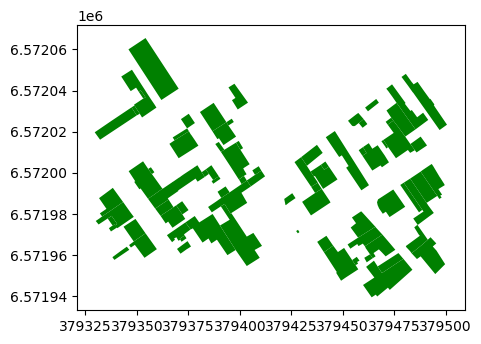

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
buildings_gdf.plot(ax=ax, color='g', alpha=1)

In [14]:
from pymdu.geometric import Vegetation, Pedestrian, Water, LandCover

water = Water(output_path="./")
water.bbox = bbox_coords
water_gdf = water.run().to_gdf()

pedestrian = Pedestrian(output_path="./")
pedestrian.bbox = bbox_coords
pedestrian_gdf = pedestrian.run().to_gdf()

vegetation = Vegetation(output_path="./", min_area=100)
vegetation.bbox = bbox_coords
vegetation_gdf = vegetation.run().to_gdf()

landcover = LandCover(
    output_path="./",
    building_gdf=buildings_gdf,
    vegetation_gdf=vegetation_gdf,
    water_gdf=water_gdf,
    cosia_gdf=None,
    dxf_gdf=None,
    pedestrian_gdf=pedestrian_gdf,
    write_file=False,
)
landcover.bbox = bbox_coords
landcover.run()
landcover_gdf = landcover.to_gdf()

[overpass] downloading data: [timeout:25][out:json];(way["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);relation["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);node["natural"="water"](46.181627,-1.152704,46.18699,-1.139893);); out body geom;


{"type":"FeatureCollection","name":"OSMPythonTools","features":[{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-1.147657,46.183413],[-1.147157,46.183211],[-1.146822,46.183103],[-1.146479,46.182971],[-1.146218,46.182815],[-1.146044,46.182602],[-1.146065,46.182177],[-1.146151,46.181804],[-1.146163,46.181986],[-1.146215,46.182176],[-1.146338,46.182384],[-1.146628,46.182625],[-1.147196,46.182988],[-1.147468,46.18321],[-1.147645,46.183374],[-1.147657,46.183413]]]},"properties":{"name":"\"natural\"=\"water\"0"}},{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-1.151472,46.184116],[-1.151612,46.184084],[-1.15164,46.184033],[-1.151535,46.183902],[-1.151411,46.183899],[-1.151321,46.18396],[-1.151291,46.184006],[-1.151321,46.184055],[-1.151472,46.184116]]]},"properties":{"name":"\"natural\"=\"water\"1"}}]}
Pedestrian error No data elements in server response. Check log and query location/tags.
Index(['Service', 'Thématique', 'Producteur', 'Nom', 'URL d'acces Geop

ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/img.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)
ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/img.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)


0...10...20...30...40...50...60...70...80...90...100 - done.


<Axes: >

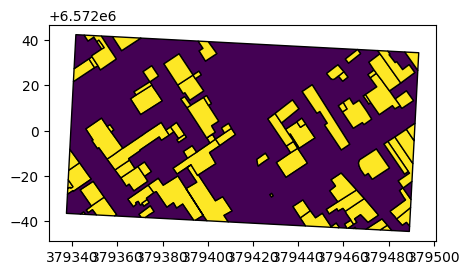

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
# buildings_gdf.plot(ax=ax, color='g', alpha=1)
# water_gdf.plot(ax=ax, color='b', alpha=1)
# vegetation_gdf.plot(ax=ax, color='r', alpha=1)
# pedestrian_gdf.plot(ax=ax, color='y', alpha=1)
landcover_gdf.plot(ax=ax, alpha=1, edgecolor="black", column="type")


## Extraction et tracé cartographique des classes COSIA

Tout d’abord, téléchargez les fichiers COSIA correspondant à votre zone d’intérêt.

CoSIA - application pour visualiser et télécharger ses cartes de Couverture du Sol par Intelligence Artificielle.

Le lien est disponible ci-dessous.

https://cosia.ign.fr/info#export

Cette cellule importe les fichiers COSIA, calcule l’intersection avec votre zone d’intérêt, puis génère une carte où chaque polygone est coloré d’après sa classe COSIA.


In [15]:
from pathlib import Path
from pymdu.geometric.Cosia import Cosia

directory_path = Path.home() / 'Downloads/CoSIA_D017_2021'

cosia = Cosia(directory_path_cosia=directory_path)
cosia.bbox = bbox_coords
cosia_gdf = cosia.run()

table_color_cosia = cosia.table_color_cosia
cosia_gdf['color'] = [table_color_cosia[x] for x in cosia_gdf.classe]

Index(['Service', 'Thématique', 'Producteur', 'Nom', 'URL d'acces Geoportail',
       'URL d'acces Geoplateforme', 'Statut de licence', 'Etat de publication',
       'Statut  Géoplateforme', 'Date actualisation de la donnée', 'Remarque'],
      dtype='object')


<Axes: >

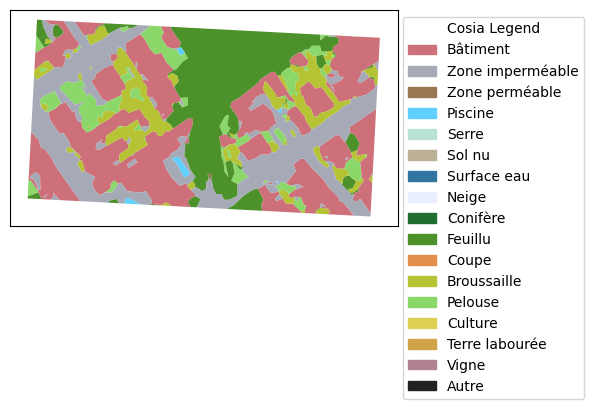

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

# Créer les patches pour chaque couleur et sa description dans la légende
patches = [
    mpatches.Patch(color=value, label=label)
    for (value, label) in zip(table_color_cosia.values(), table_color_cosia.keys())
]

# Ajouter la légende personnalisée
plt.legend(
    handles=patches,
    loc="upper right",
    title="Cosia Legend",
    bbox_to_anchor=(1.5, 1.)
)
ax.set_xticks([])
ax.set_yticks([])
cosia_gdf.plot(ax=ax, edgecolor=None, color=cosia_gdf['color'])

## Création de la couche d’occupation du sol et sauvegarde

1. Définition du chemin de sortie (`results_demo`).
2. Instanciation de `pymdu.geometric.LandCover` avec les jeux de données disponibles (ici COSIA).
3. Lancement du traitement pour obtenir `landcover_gdf`.

In [17]:
from pymdu.geometric.LandCover import LandCover

output_path = os.path.join(os.getcwd(), 'results_demo')
os.makedirs(output_path, exist_ok=True)

landcover = LandCover(output_path=output_path,
                      building_gdf=None,
                      vegetation_gdf=None,
                      cosia_gdf=cosia_gdf,
                      dxf_gdf=None,
                      pedestrian_gdf=None,
                      water_gdf=None)

landcover_gdf = landcover.run(keep_geom_type=True).to_gdf()
landcover.bbox = bbox_coords
landcover.to_shp(name='landcover')

landcover.create_landcover_from_cosia(os.path.join(inputs_simulation_path, "landcover.tif"))

<Axes: title={'center': 'Landcover (Cosia)'}>

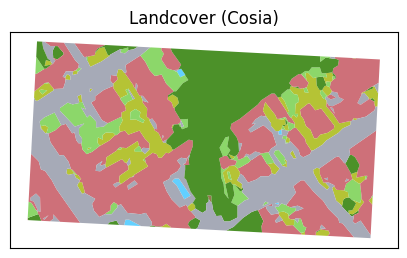

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
plt.title('Landcover (Cosia)')
landcover.gdf.plot(ax=ax, color=landcover_gdf["color"], alpha=1)

## Création de la couche DEM: Digital Elevation Model

Dans cette section, nous procédons à la création de la couche DEM (Digital Elevation Model), qui représente le modèle numérique de terrain pour la zone d'étude. Les données nécessaires à la construction de cette couche sont téléchargées à partir du serveur de l'IGN (Institut Géographique National), garantissant ainsi une haute précision et une couverture complète du territoire concerné.


Le DEM ne prend pas en compte les objets présents à la surface du terrain tels que les plantes et les bâtiments.

In [20]:
from pymdu.geometric.Dem import Dem

dem = Dem(output_path=inputs_simulation_path)
dem.bbox = bbox_coords
dem.run()

Index(['Service', 'Thématique', 'Producteur', 'Nom', 'URL d'acces Geoportail',
       'URL d'acces Geoplateforme', 'Statut de licence', 'Etat de publication',
       'Statut  Géoplateforme', 'Date actualisation de la donnée', 'Remarque'],
      dtype='object')
key=> dem
['ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES'
 'ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES']
https://data.geopf.fr/wms-r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities
width_px 151 height_px 79
URL  :  /var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/dem.tiff


ERROR 1: _TIFFVSetField:/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/dem.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)


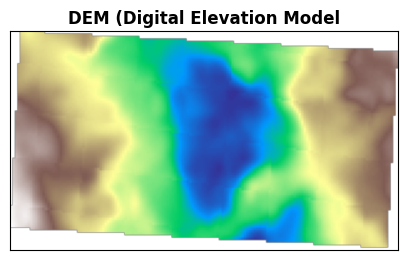

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(inputs_simulation_path, "DEM.tif"))
rasterio.plot.show(raster, ax=ax, title="DEM (Digital Elevation Model", cmap='terrain')
plt.show()

## Découpage et reprojection du DEM avec GDAL

In [22]:
import subprocess

inraster = os.path.join(inputs_simulation_path, "DEM.tif")
outraster = os.path.join(output_path, "DEM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")
subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

Creating output file that is 132P x 74L.
Using internal nodata values (e.g. -99999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif to destination /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DEM.tif.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

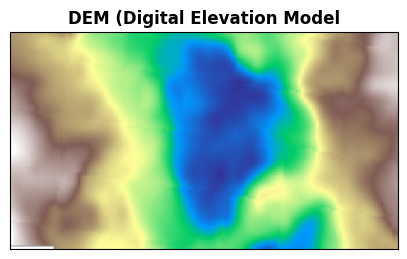

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DEM.tif"))
rasterio.plot.show(raster, ax=ax, title="DEM (Digital Elevation Model", cmap='terrain')
plt.show()

## Homégénéisation des rasters

Dans cette étape, nous procédons à l'homogénéisation des rasters utilisés pour les différentes couches géospatiales. Lors de la manipulation des données raster, les différences de projections peuvent entraîner des décalages spatiaux entre les couches, ce qui pourrait compromettre la précision des analyses.

Pour garantir que les résultats des simulations soient cohérents et fiables, il est essentiel de s'assurer que tous les rasters ont la même taille et les mêmes dimensions.


In [24]:
from osgeo import gdal, gdalconst
from pymdu.image.geotiff import raster_file_like

gdal.AllRegister()
warp_options = gdal.WarpOptions(format='GTiff',
                                xRes=1, yRes=1,
                                outputType=gdalconst.GDT_Float32,
                                dstNodata=None,
                                dstSRS='EPSG:2154',
                                cropToCutline=True,
                                cutlineDSName=os.path.join(inputs_simulation_path, 'mask.shp'),
                                cutlineLayer='mask')

gdal.Warp(destNameOrDestDS=os.path.join(output_path, 'landcover_clip.tif'),
          srcDSOrSrcDSTab=os.path.join(inputs_simulation_path, 'landcover.tif'),
          options=warp_options)

raster_file_like(src_tif=os.path.join(output_path, "landcover_clip.tif"),
                 dst_tif=os.path.join(output_path, "landcover.tif"),
                 like_path=os.path.join(output_path, "DEM.tif"),
                 remove_nan=True)

Pas besoin de re-découper


<xarray.DataArray (band: 1, y: 74, x: 132)> Size: 39kB
array([[[6., 6., ..., 1., 1.],
        [2., 6., ..., 2., 2.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 1kB 3.793e+05 3.794e+05 ... 3.795e+05 3.795e+05
  * y            (y) float64 592B 6.572e+06 6.572e+06 ... 6.572e+06 6.572e+06
    spatial_ref  int64 8B 0
Attributes:
    long_name:      type
    name:           type
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

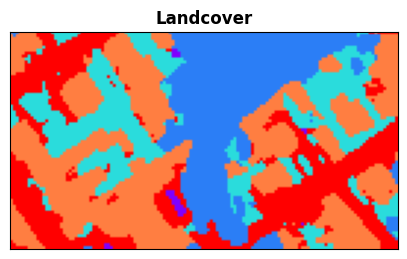

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "landcover.tif"))
rasterio.plot.show(raster, ax=ax, title="Landcover", cmap='rainbow_r')
plt.show()

## Construction de la couche DSM

Dans cette étape, nous procédons à la construction de la couche DSM (Digital Surface Model), qui est représentée par le fichier `DSM.tif`.

Dans le cadre du code `Solweig`, cette couche joue un rôle essentiel car elle représente la hauteur des éléments présents à la surface, tels que les bâtiments, la végétation, et autres structures. Contrairement au modèle numérique de terrain (DEM) qui ne prend en compte que la topographie du sol, le DSM inclut l'élévation des objets se trouvant au-dessus du sol.

In [28]:
from pymdu.physics.umep.DsmModelGenerator import DsmModelGenerator

dsm = DsmModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    input_filepath_dem=os.path.join(inputs_simulation_path, "DEM.tif"),
    input_building_shp_path=os.path.join(inputs_simulation_path, "buildings.shp"),
    input_mask_shp_path=os.path.join(inputs_simulation_path, "mask.shp")

)
dsm.run()

inraster = os.path.join(inputs_simulation_path, f"DSM.tif")
outraster = os.path.join(output_path, f"DSM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
extent 379349.174281542,379481.6612729233,6571961.947775265,6572035.952072561 [EPSG:2154]
Processing UMEP umep:Spatial Data: DSM Generator
{'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DEM.tif', 'INPUT_POLYGONLAYER': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/buildings.shp', 'INPUT_FIELD': 'hauteur', 'USE_OSM': False, 'BUILDING_LEVEL': 3.1, 'EXTENT': '379349.174281542,379481.6612729233,6571961.947775265,6572035.952072561 [EPSG:2154]', 'PIXEL_RESOLUTION': 1, 'OUTPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif'}
Processing UMEP EXIT umep:Spatial Data: DSM Generator
Creating output file that is 132P x 74L.
Using internal nodata values (e.g. -9999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/py

0

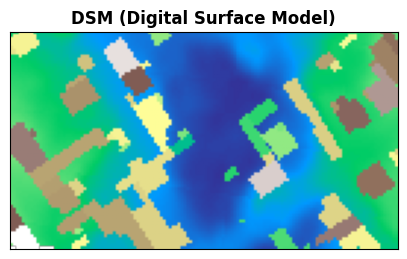

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DSM.tif"))
rasterio.plot.show(raster, ax=ax, title="DSM (Digital Surface Model)", cmap='terrain')
plt.show()

## Extraction des arbres à partir de données LiDAR

Le LiDAR (Light Detection And Ranging) est une méthode de télédétection par laser qui fournit un nuage de points 3D extrêmement précis de la surface du sol et de la végétation.

Dans cette étape, nous exploitons ces données pour détecter les arbres au sein de notre zone d’intérêt.
Avec la classe `Lidar` de `pymdu` :
- Nous chargeons les données LiDAR,
- Appliquons la bounding box définie précédemment,
- Exécutons l’algorithme de détection des arbres,
- Et exportons les emplacements des arbres sous forme de shapefile.

In [60]:
from pymdu.image.Lidar import Lidar

lidar = Lidar(output_path=inputs_simulation_path)
lidar_tif = lidar.to_tif(write_out_file=True, classification_list=[3, 4, 5, 9])

<Response [200]>


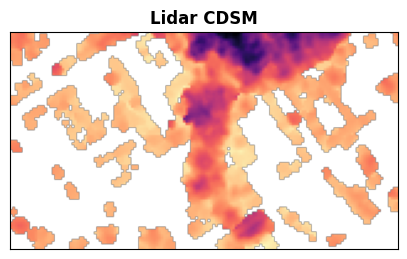

In [41]:
# Lire les données et les afficher avec rasterio.plot
with lidar_tif.open() as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    rasterio.plot.show(src, ax=ax, title="Lidar CDSM", cmap='magma_r')
    plt.show()

In [34]:
lidar.bbox = bbox_coords
lidar_trees_gdf = lidar.run_trees()
lidar_trees_gdf.to_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

<Response [200]>
Projected BBOX (EPSG:2154): [379337.48425289075, 379493.35130157456, 6571963.412100571, 6572034.487851155]
DSM.tif saved successfully.
DTM.tif saved successfully.
CHM.tif saved successfully.
Detected 9 tree top candidates.
Extracted 9 crown polygons.
Tree crowns saved to 'tree_crowns.shp'.
Tree tops saved to 'tree_tops.shp'.


<Axes: >

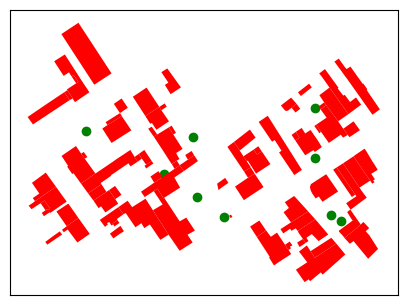

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
lidar_trees_gdf.plot(ax=ax, color='g', alpha=1)
buildings_gdf.plot(ax=ax, color='r', alpha=1)

## Construction de la couche CDSM et TDSM

Dans cette étape, nous procédons à la construction des couches `CDSM` (Canopy Digital Surface Model) et `TDSM` (Tree Digital Surface Model), qui sont essentielles pour les simulations dans le cadre du code `Solweig`. La couche `CDSM` représente un modèle numérique de surface spécifique à la canopée urbaine, c'est-à-dire les éléments au-dessus du sol qui ne sont pas des bâtiments, principalement des haies et le tronc des arbres.

De son côté, la couche `TDSM` est dédiée à la représentation des arbres. Elle modélise l'élévation des arbres, ce qui permet d'analyser leur contribution à la régulation thermique et à la réduction des îlots de chaleur en milieu urbain.


In [53]:
from pymdu.physics.umep.SurfaceModelGenerator import SurfaceModelGenerator

trees_path = os.path.join(inputs_simulation_path, 'lidar_trees.shp')

surface_model = SurfaceModelGenerator(
    working_directory=inputs_simulation_path,
    input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
    input_filepath_dem=os.path.join(output_path, "DEM.tif"),
    input_filepath_tree_shp=trees_path,
    output_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    output_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif")
)
surface_model.run()
list_files = ['CDSM', 'TDSM']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Spatial Data: Tree Generator
{'INPUT_POINTLAYER': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/lidar_trees.shp', 'TREE_TYPE': 'type', 'TOT_HEIGHT': 'height', 'TRUNK_HEIGHT': 'trunk zone', 'DIA': 'diameter', 'INPUT_BUILD': None, 'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DEM.tif', 'INPUT_CDSM': None, 'INPUT_TDSM': None, 'CDSM_GRID_OUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif', 'TDSM_GRID_OUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/TDSM.tif'}
Processing UMEP EXIT umep:Spatial Data: Tree Generator
Creating output file that is 132P x 74L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100

## Construction de la couche `HEIGHT` et `ASPECT`

Dans cette étape, nous procédons à la construction des couches `HEIGHT` et `ASPECT`, qui jouent un rôle crucial dans les simulations climatiques effectuées avec le code `Solweig`.

La couche `HEIGHT` représente la hauteur des structures urbaines, telles que les bâtiments, par rapport au niveau du sol. Cette information est fondamentale pour évaluer l'impact des différentes hauteurs sur la distribution des ombres, la répartition des rayonnements solaires, et, par conséquent, sur la température ressentie dans l'environnement urbain.

La couche `ASPECT`, indique l'orientation des pentes et des surfaces par rapport aux points cardinaux. Cette orientation est essentielle pour comprendre comment les surfaces captent ou réfléchissent la lumière du soleil tout au long de la journée, influençant directement la distribution des températures et des conditions microclimatiques au sein du quartier.


In [54]:
from pymdu.physics.umep.HeightAspectModelGenerator import HeightAspectModelGenerator

height_aspect_model = HeightAspectModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_height=os.path.join(inputs_simulation_path, "HEIGHT.tif"),
    output_filepath_aspect=os.path.join(inputs_simulation_path, "ASPECT.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),

)
height_aspect_model.run()

list_files = ['HEIGHT', 'ASPECT']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Wall Height and Aspect
{'INPUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif', 'INPUT_LIMIT': 3, 'OUTPUT_HEIGHT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/HEIGHT.tif', 'OUTPUT_ASPECT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/ASPECT.tif'}
Processing UMEP EXIT umep:Urban Geometry: Wall Height and Aspect
Creating output file that is 132P x 74L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/HEIGHT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 132P x 74L.
Processing /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/ASPECT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


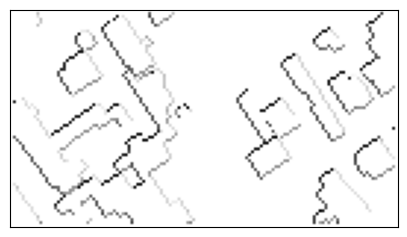

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "ASPECT.tif"))
rasterio.plot.show(raster, ax=ax, cmap='binary')
plt.show()

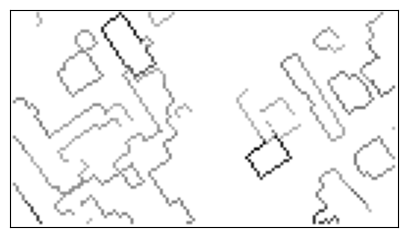

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "HEIGHT.tif"))
rasterio.plot.show(raster, ax=ax, cmap='binary')
plt.show()

## Construction de la couche `SkyViewFactor`

Dans cette étape, nous procédons à la construction de la couche `SkyViewFactor`, qui est une composante essentielle pour les simulations climatiques dans le cadre du code `Solweig`. Le Sky View Factor (SVF) est un indicateur qui mesure la proportion du ciel visible depuis un point donné au sol. Il est particulièrement important dans les environnements urbains denses, où les bâtiments et autres structures peuvent obstruer la vue du ciel, réduisant ainsi l'exposition au rayonnement solaire direct et affectant la température ressentie.

`Solweig` se distingue par sa capacité à utiliser des Sky View Factors directionnels, ce qui signifie qu'il prend en compte la visibilité du ciel dans différentes directions (nord, sud, est, ouest) pour chaque point de la zone étudiée. Cette approche directionnelle permet une modélisation plus fine des interactions entre les bâtiments, les ombres, et le climat urbain.


In [58]:
from pymdu.physics.umep.SVFModelGenerator import SVFModelGenerator

svf_model = SVFModelGenerator(
    working_directory=output_path,
    input_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif"),
    input_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    ouptut_filepath_svf=os.path.join(inputs_simulation_path, "SVF.tif"),
)
svf_model.run()

inraster = os.path.join(inputs_simulation_path, "SVF.tif")
outraster = os.path.join(output_path, "SVF_clip.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Sky View Factor
{'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/DSM.tif', 'INPUT_CDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/TDSM.tif', 'INPUT_THEIGHT': 25.0, 'ANISO': True, 'OUTPUT_DIR': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo', 'OUTPUT_FILE': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif'}
Processing UMEP EXIT umep:Urban Geometry: Sky View Factor
Creating output file that is 132P x 74L.
Using internal nodata values (e.g. -9999) for image /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif.
Copying nodata values from source /Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/inputs_simulation/SVF.tif to desti

0

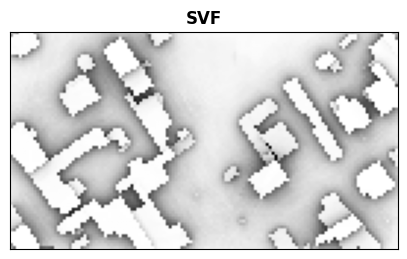

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "SVF_clip.tif"))
rasterio.plot.show(raster, ax=ax, title="SVF", cmap='gray')
plt.show()

In [39]:
from pymdu.meteo.Meteo import Meteo

meteo_file = Meteo(output_path=r"./")
meteo_file.bbox = bbox_coords
meteo_file.run(begin="2024-06-30 15:00:00",
               end="2024-06-30 17:00:00")


WEATHERFILE_PATH FOUND FRA_AC_La.Rochelle.073150_TMYx.2004-2018.epw
                     Year  Month  Day  Hour  Minute  \
2024-06-30 15:00:00  2014      7    1    16      60   
2024-06-30 16:00:00  2014      7    1    17      60   
2024-06-30 17:00:00  2014      7    1    18      60   

                                Data Source and Uncertainty Flags  \
2024-06-30 15:00:00  ?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9*9*9   
2024-06-30 16:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   
2024-06-30 17:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   

                     Dry Bulb Temperature  Dew Point Temperature  \
2024-06-30 15:00:00                  25.2                   12.4   
2024-06-30 16:00:00                  24.7                   12.3   
2024-06-30 17:00:00                  24.2                   11.5   

                     Relative Humidity  Atmospheric Station Pressure  \
2024-06-30 15:00:00                 45                        101209   
2024-06-30 16:00:

In [40]:
from pymdu.physics.umep.Solweig import Solweig

d = Solweig(meteo_path='FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt',
            output_dir=output_path,
            working_directory=output_path,
            input_filepath_landcover=os.path.join(output_path, "landcover.tif"),
            input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
            input_filepath_dem=os.path.join(output_path, "DEM.tif"),
            input_filepath_cdsm=os.path.join(output_path, "CDSM.tif"),
            input_filepath_tdsm=os.path.join(output_path, "TDSM.tif"),
            input_filepath_height=os.path.join(output_path, "HEIGHT.tif"),
            input_filepath_aspect=os.path.join(output_path, "ASPECT.tif"),
            input_filepath_shadowmats_npz=os.path.join(output_path, "shadowmats.npz"),
            input_filepath_svf_zip=os.path.join(output_path, "svfs.zip"))
d.run()



__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Outdoor Thermal Comfort: SOLWEIG
{'INPUT_DSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'INPUT_SVF': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/svfs.zip', 'INPUT_HEIGHT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/HEIGHT.tif', 'INPUT_ASPECT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/ASPECT.tif', 'INPUT_CDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/TDSM.tif', 'INPUT_THEIGHT': 25, 'INPUT_LC': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/landcover.tif', 'USE_LC_BUILD': False, 'INPUT_DEM': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/DSM.tif', 'SAVE_BUILD': False, 'INPUT_ANISO': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/shadowmats.npz', 'ALBEDO_WALLS': 0.2, 'ALBEDO_GROUND': 0.15, 'EMIS_WALL

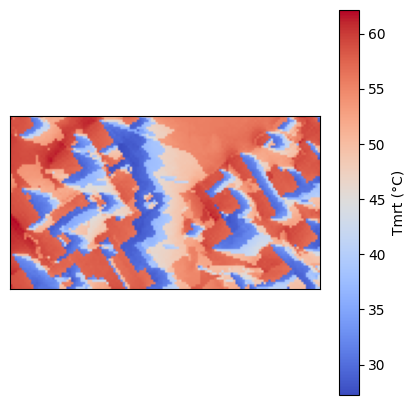

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "Tmrt_average.tif"))
img = rasterio.plot.show(raster, ax=ax, cmap='coolwarm')
plt.colorbar(img.get_images()[0], ax=ax, label='Tmrt (°C)')
plt.show()

## Lancement UROCK

In [42]:
import geopandas as gpd
from pymdu.geometric.UrockFiles import UrockFiles

batiments = gpd.read_file(os.path.join(inputs_simulation_path, 'buildings.shp'))
arbres = gpd.read_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

urock = UrockFiles(output_path, batiments, arbres)
urock.generate_urock_buildings().to_file(os.path.join(output_path, 'batiments_urock.shp'), driver="ESRI Shapefile")
urock.generate_urock_trees().to_file(os.path.join(output_path, 'arbres_urock.shp'), driver="ESRI Shapefile")

 # UMEP Plugins

 1. telecharger https://github.com/UMEP-dev/UMEP -> renommer umep
 2. https://github.com/UMEP-dev/UMEP-processing -> renommer processing_umep

.local/share/QGIS/QGIS3/profiles/default/python/plugins

/anaconda3/envs/pymdu/share/qgis/python/plugins


In [64]:
output_path_urock = os.path.join(output_path, 'output_urock')
os.makedirs(output_path_urock, exist_ok=True)

from pymdu.physics.umep.UmepCore import UmepCore

for direction in range(50, 55, 10):
    options_umep_urock = {
        'BUILDINGS': os.path.join(output_path, 'batiments_urock.shp'),
        'HEIGHT_FIELD_BUILD': 'hauteur',
        'VEGETATION': os.path.join(output_path, 'arbres_urock.shp'),
        'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT',
        'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT',
        'ATTENUATION_FIELD': 'ATTENUATIO',
        'INPUT_PROFILE_FILE': '',
        'INPUT_PROFILE_TYPE': 0,
        'INPUT_WIND_HEIGHT': 10,
        'INPUT_WIND_SPEED': 1,
        'INPUT_WIND_DIRECTION': direction,
        'RASTER_OUTPUT': None,
        'HORIZONTAL_RESOLUTION': 1,
        'VERTICAL_RESOLUTION': 10,
        'WIND_HEIGHT': '2',
        'UROCK_OUTPUT': output_path_urock,
        'OUTPUT_FILENAME': f'output_{direction}',
        'SAVE_RASTER': False,
        'SAVE_VECTOR': False,
        'SAVE_NETCDF': True,
        'LOAD_OUTPUT': True
    }

    umep_core = UmepCore(output_dir=output_path_urock)

    umep_core.run_processing(
        name="umep:Urban Wind Field: URock",
        options=options_umep_urock
    )

__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Wind Field: URock
{'BUILDINGS': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/batiments_urock.shp', 'HEIGHT_FIELD_BUILD': 'hauteur', 'VEGETATION': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/arbres_urock.shp', 'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT', 'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT', 'ATTENUATION_FIELD': 'ATTENUATIO', 'INPUT_PROFILE_FILE': '', 'INPUT_PROFILE_TYPE': 0, 'INPUT_WIND_HEIGHT': 10, 'INPUT_WIND_SPEED': 1, 'INPUT_WIND_DIRECTION': 50, 'RASTER_OUTPUT': None, 'HORIZONTAL_RESOLUTION': 1, 'VERTICAL_RESOLUTION': 10, 'WIND_HEIGHT': '2', 'UROCK_OUTPUT': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock', 'OUTPUT_FILENAME': 'output_50', 'SAVE_RASTER': False, 'SAVE_VECTOR': False, 'SAVE_NETCDF': True, 'LOAD_OUTPUT': True}
Connecting to database
	->/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/myDbH21749721568_389127
/Users/Boris

## Calcul d'un raster d'UTCI
a verifier car utilise netCDF

In [65]:
src_nc = os.path.join(output_path_urock, f'output_{direction}.nc')
umep_core = UmepCore(output_dir=output_path_urock)

options_umep_urock_analyze = {
    'INPUT_LINES': None,
    'IS_STREAM': False,
    'ID_FIELD_LINES': '',
    'INPUT_POLYGONS': None,
    'ID_FIELD_POLYGONS': '',
    'INPUT_WIND_FILE': src_nc,
    'SIMULATION_NAME': '',
    'OUTPUT_DIRECTORY': output_path_urock
}
umep_core.run_processing(
    name="umep:Urban Wind Field: URock analyzer",
    options=options_umep_urock_analyze
)


__init__ QGisCore
__init__ qgsApp
platform.system() Darwin
__init__ UmepCore
Processing UMEP umep:Urban Wind Field: URock analyzer
{'INPUT_LINES': None, 'IS_STREAM': False, 'ID_FIELD_LINES': '', 'INPUT_POLYGONS': None, 'ID_FIELD_POLYGONS': '', 'INPUT_WIND_FILE': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock/output_50.nc', 'SIMULATION_NAME': '', 'OUTPUT_DIRECTORY': '/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock'}
Connecting to database
	->/var/folders/zh/f2j36cz90lzfcn8r42snc4nc0000gr/T/myDbH21749721610_697598
/Users/Boris/miniforge3/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/URock/h2gis-standalone/h2gis-dist-2.2.3.jar
Connected!

Spatial functions added!

Processing UMEP EXIT umep:Urban Wind Field: URock analyzer


In [66]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
import rioxarray
from tqdm import tqdm
from pythermalcomfort.models import utci
import os

METEO_FILE = 'FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt'
METEO_DATA = pd.read_csv(METEO_FILE, sep=' ')

output_path = os.path.join(os.getcwd(), 'results_demo')
output_path_urock = os.path.join(output_path, 'output_urock')
direction = 50

TMRT_PATH = os.path.join(output_path, 'Tmrt_2024_182_1660D.tif')
TMRT_dataset = rioxarray.open_rasterio(TMRT_PATH)
tmr_as_array = TMRT_dataset.data[0]
size1, size2 = tmr_as_array.shape

wind_velocity = 4.1
HEURE = 16

src_nc = os.path.join(output_path_urock, f'output_{direction}.nc')
nc = Dataset(src_nc)
grp = nc.groups['3D_wind']
Z = grp.variables['Z'][:]
level_idx = np.argmin(np.abs(Z - 10))  # 10 meter

wx = grp.variables['windSpeed_x'][:, :, level_idx]
wy = grp.variables['windSpeed_y'][:, :, level_idx]
wind_as_array = wind_velocity * np.sqrt(wx ** 2 + wy ** 2)

tmrt_shape = tmr_as_array.shape
zoom_factors = (tmrt_shape[0] / wind_as_array.shape[0], tmrt_shape[1] / wind_as_array.shape[1])
wind_as_array_resized = zoom(wind_as_array, zoom_factors, order=1)

output = np.zeros(shape=(size1, size2))
tdb = METEO_DATA[METEO_DATA.it == HEURE].Td.values[0]
rh = METEO_DATA[METEO_DATA.it == HEURE].RH.values[0]
for i in tqdm(range(0, size1)):
    output[i, :] = utci(tdb=tdb, tr=tmr_as_array[i, :], v=wind_as_array_resized[i, :], rh=rh, limit_inputs=False)
UTCI_dataset = TMRT_dataset.copy()
UTCI_dataset.data[0] = output


100%|██████████| 74/74 [00:00<00:00, 18101.04it/s]


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

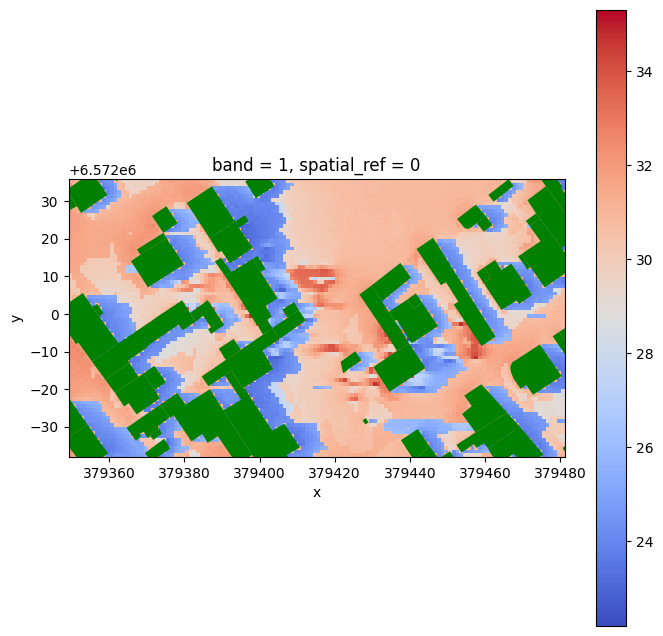

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))
UTCI_dataset.plot(ax=ax, cmap='coolwarm')
buildings_gdf.plot(ax=ax, color='g', alpha=1)

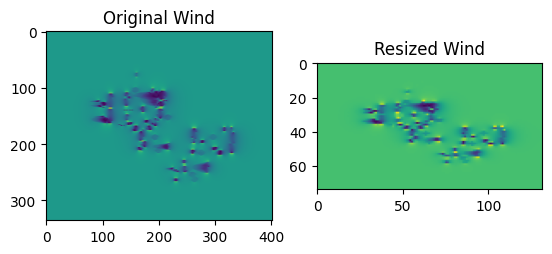

In [85]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1);
plt.imshow(wind_as_array);
plt.title("Original Wind")
plt.subplot(1, 2, 2);
plt.imshow(wind_as_array_resized);
plt.title("Resized Wind")
plt.show()


In [68]:
import xarray as xr

src_nc = os.path.join("/Users/Boris/Documents/TIPEE/pymdu/demos/results_demo/output_urock", f'output_50.nc')

# Ouvrir le NetCDF avec rioxarray
ds = xr.open_dataset(src_nc, group="3D_wind")

da = ds["windSpeed_x"].isel(z=1)

# Activer l’attribut spatial (coordonnée CRS actuelle)
da.rio.set_spatial_dims(x_dim="rlon", y_dim="rlat", inplace=True)
da.rio.write_crs("EPSG:4326", inplace=True)

# Reprojection vers EPSG:2154 (Lambert-93)
#da_l93 = da.rio.reproject("EPSG:2154")

# Sauvegarder au format NetCDF reprojeté
da.to_netcdf("fichier_l93.nc")

In [69]:
da

<xarray.DataArray 'windSpeed_x' (rlon: 336, rlat: 401)> Size: 539kB
[134736 values with dtype=float32]
Coordinates:
  * rlon         (rlon) int32 1kB 0 1 2 3 4 5 6 ... 329 330 331 332 333 334 335
  * rlat         (rlat) int32 2kB 0 1 2 3 4 5 6 ... 394 395 396 397 398 399 400
    spatial_ref  int64 8B 0
Attributes:
    units:    meter per second

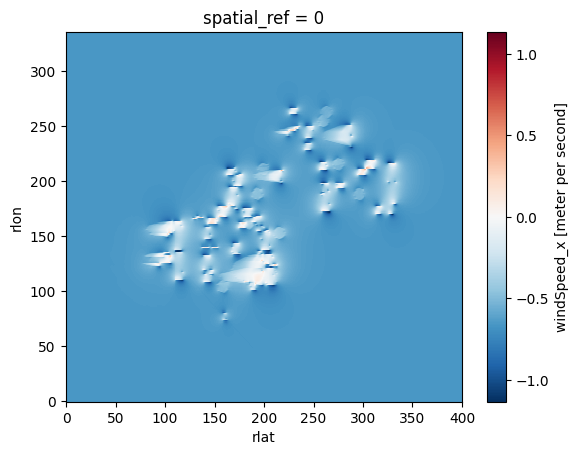

In [71]:
%matplotlib inline
da.plot()